# Uso de Transformers para clasificación de texto.

Vamos a hacer uso de transformers ya que estos funcionan especialmente bien para el tratamiento del texto y para modelos de clasificación de este. Estos se encargan de Tokenizar el texto conservando informaciones relevantes como el contexto o el orden de las palabras. Cosas que con otras técnicas como TF-IDF no es posible.

In [14]:
import pandas as pd
import os
from torch.utils.data import DataLoader,Dataset
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, BertModel,Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
import lime
import shap
from lime.lime_text import LimeTextExplainer
import random

In [6]:
df = pd.read_csv("fake_news_dataset.csv")

df_reducido = df[["title", "text", "label"]].copy()
df_reducido["combined"] = df_reducido["title"] + "[SEP]" + df_reducido["text"]
df_reducido['label'] = df_reducido['label'].map({'fake': 0, 'real': 1})
df_reducido.drop(columns=["title", "text"], inplace=True)

display(df_reducido.head())

,label,combined
0,1,Foreign Democrat final.[SEP]more tax developme...
1,0,To offer down resource great point.[SEP]probab...
2,0,Himself church myself carry.[SEP]them identify...
3,0,You unit its should.[SEP]phone which item yard...
4,0,Billion believe employee summer how.[SEP]wonde...


In [7]:
# Evaluación
def evaluar_prediccion(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))

    labels = ["Fake", "Real"]

    # Dibujar
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicción")
    plt.ylabel("Valor real")
    plt.title("Matriz de Confusión")
    plt.tight_layout()
    plt.show()

Ahora una vez preparado nuestro dataframe para poder usar un BERT base vamos a preparar los datos para el entrenamiento. Para ello creamos un dataframe cuyos campos son la salida del tensor de pytorch, esto con el fin de poder tener un dataframe con los tokens codificados por el encoder de BERT.

In [22]:
# Dividir en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(
    df_reducido["combined"].tolist(), df_reducido["label"].tolist(), test_size=0.2
)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=1000)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=200)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

Una vez listo todos nuestros datos, vamos a entrenar el modelo. Esto lo haremos al principio solo con el texto para ver como se comporta un modelos de transformer como BERt solo con los datos de texto de los que disponemos.

In [23]:
# Configuración de Early Stopping
early_stop_patience = 10  # Número de épocas/batches sin mejora antes de parar
min_delta = 0.001  # Cambio mínimo para considerar mejora
best_loss = float('inf')
no_improve_count = 0
stop_training = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
optim = AdamW(model.parameters(), lr=1e-8)

# Historial para tracking
history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': []
}

for epoch in range(3):
    if stop_training:
        print("\nEarly stopping triggered!")
        break
        
    print(f"\nEpoch {epoch + 1}/3")
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    for batch_idx, batch in enumerate(train_loader):
        if stop_training:
            break
            
        model.train()
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optim.step()

        # Acumular métricas
        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        
        # Guardar métricas del batch
        batch_accuracy = accuracy_score(all_labels, all_preds)
        history['batch_loss'].append(loss.item())
        history['batch_accuracy'].append(batch_accuracy)
        
        # Early Stopping a nivel de batch
        if (batch_idx + 1) % 10 == 0:
            avg_loss = epoch_loss / (batch_idx + 1)
            print(f"  Batch {batch_idx + 1} | Running Avg Loss: {avg_loss:.4f} | Running Accuracy: {batch_accuracy:.4f}")
            
            # Verificar mejora (puedes usar loss o accuracy)
            current_loss = avg_loss
            if current_loss < (best_loss - min_delta):
                best_loss = current_loss
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= early_stop_patience:
                    print(f"\nEarly stopping at batch {batch_idx + 1} - No improvement for {early_stop_patience} checks")
                    stop_training = True
                    break

    # Métricas finales de la época
    final_loss = epoch_loss / len(train_loader)
    final_accuracy = accuracy_score(all_labels, all_preds)
    history['epoch_loss'].append(final_loss)
    history['epoch_accuracy'].append(final_accuracy)
    
    print(f"\nEpoch {epoch + 1} Summary | Loss: {final_loss:.4f} | Accuracy: {final_accuracy:.4f}\n")
    
    # Early Stopping a nivel de época
    if final_loss < (best_loss - min_delta):
        best_loss = final_loss
        no_improve_count = 0
        # Guardar el mejor modelo
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improve_count += 1
        if no_improve_count >= early_stop_patience:
            print(f"\nEarly stopping at epoch {epoch + 1} - No improvement for {early_stop_patience} epochs")
            stop_training = True

model.eval()

# Cargar el mejor modelo antes de evaluar
if os.path.exists('best_model.pt'):
    model.load_state_dict(torch.load('best_model.pt'))
    print("\nLoaded best model weights for evaluation.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB. GPU 0 has a total capacity of 5.77 GiB of which 110.12 MiB is free. Process 11134 has 82.00 MiB memory in use. Including non-PyTorch memory, this process has 4.89 GiB memory in use. Of the allocated memory 4.12 GiB is allocated by PyTorch, and 669.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Una vez entrenado el modelo pasamos a ver la predicciones de este con el dataset generado de prueba para ver los resultados de la predicción de estos.

              precision    recall  f1-score   support

           0       0.50      0.44      0.47      2026
           1       0.49      0.55      0.52      1974

    accuracy                           0.49      4000
   macro avg       0.50      0.50      0.49      4000
weighted avg       0.50      0.49      0.49      4000



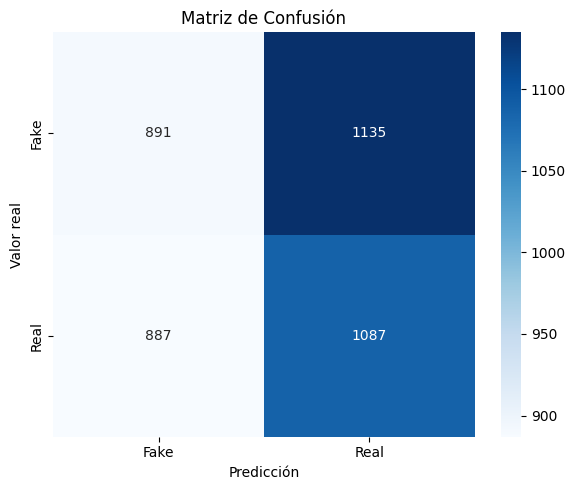

In [10]:
test_loader = DataLoader(test_dataset, batch_size=16)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
print(classification_report(all_labels, all_preds))

labels = ["Fake", "Real"] 

# Dibujar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

Tras realizar un modelo que clasifica solo haciendo uso de los valores de texto del dataset, procedemos a agregar todos los valores normalizados al modelo de BERT.

In [ ]:
df_encoded = pd.read_csv("datos_limpios_estandarizados.csv")
df_encoded[['title', 'text']] = df_encoded[['title', 'text']].fillna("")

text_data = (df_encoded['title'] + " " + df_encoded['text']).tolist()
numeric_features = df_encoded.drop(columns=['title', 'text', 'label']).astype('float32').values
labels = df_encoded['label'].values

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

encodings = tokenizer(text_data, truncation=True, padding=True, max_length=512, return_tensors='pt')

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    text_data, numeric_features, labels,
    test_size=0.2,         # 20% para prueba
    random_state=42,       # Para reproducibilidad
    stratify=labels        # Mantiene proporción de clases
)

encodings_train = tokenizer(X_text_train, truncation=True, padding=True, max_length=5000, return_tensors='pt')
encodings_test = tokenizer(X_text_test, truncation=True, padding=True, max_length=5000, return_tensors='pt')

Para esto hay que distinguier ahora en el dataset a generar con los datos codificados del texto, los datos de los valores numéricos correspondiente al resto de datos.

In [4]:
class NewsDataset(Dataset):
    def __init__(self, encodings, numeric_feats, labels):
        self.encodings = encodings
        self.numeric_feats = torch.tensor(numeric_feats, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['numeric_feats'] = self.numeric_feats[idx]
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(encodings_train, X_num_train, y_train)
test_dataset = NewsDataset(encodings_test, X_num_test, y_test)

Para poder hacer un modelo que clasifique teniendo en cuenta ambos, hay que hacer un modelo hibrído en el cual se tenga en cuenta la clasificación de los valores de texto codificados y luego esto junto a los valores numéricos pasen a una red de neuronas que termine la clasificación.

In [5]:
class BertWithNumericFeatures(nn.Module):
    def __init__(self, text_model_name, num_numeric_feats):
        super().__init__()
        self.bert = BertModel.from_pretrained(text_model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + num_numeric_feats, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Para clasificación binaria
        )

    def forward(self, input_ids, attention_mask, numeric_feats, labels=None):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = bert_outputs.pooler_output  # [batch, hidden_size]

        combined = torch.cat((cls_output, numeric_feats), dim=1)
        logits = self.classifier(self.dropout(combined))

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

In [6]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    do_eval=True, 
    logging_dir='./logs',
)

def compute_metrics(p):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

trainer = Trainer(
    model=BertWithNumericFeatures('bert-base-uncased', numeric_features.shape[1]),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # deberías separar train/test idealmente
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss
500,0.696000
1000,0.694300
1500,0.693400
2000,0.693300
2500,0.694000


TrainOutput(global_step=2709, training_loss=0.6940964944866936, metrics={'train_runtime': 1884.1278, 'train_samples_per_second': 22.986, 'train_steps_per_second': 1.438, 'total_flos': 0.0, 'train_loss': 0.6940964944866936, 'epoch': 3.0})

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.51      0.60      0.55      1819
           1       0.50      0.40      0.45      1790

    accuracy                           0.50      3609
   macro avg       0.50      0.50      0.50      3609
weighted avg       0.50      0.50      0.50      3609



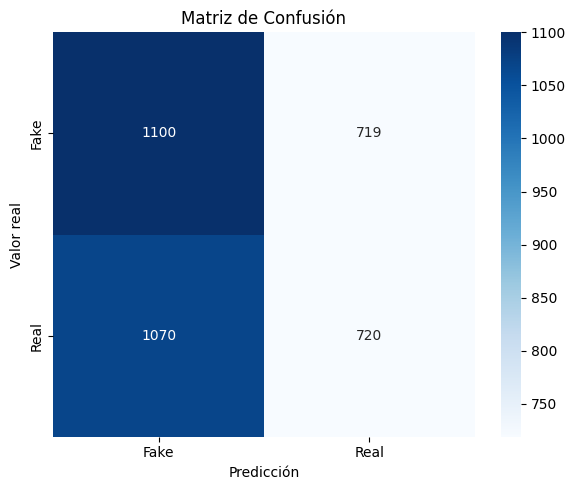

In [8]:
predictions = trainer.predict(test_dataset)


y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)
evaluar_prediccion(y_true, y_pred)